In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


#  Importing Libraries

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import string
import re
import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve , auc, RocCurveDisplay

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Loading and viewing data

In [3]:
data=pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")

In [4]:
data.shape  # no.of rows and columns present 

(13636, 15)

In [5]:
data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review'],
      dtype='object')

In [6]:
data.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [7]:
data.info()   #checking for datatypes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [8]:
#converting unix CreationTimestamp to time date format
data['CreationTimestamp']=pd.to_datetime(data['CreationTimestamp'])

In [9]:
data.isnull().sum()  #checking for null values

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

In [10]:
Percentage=data['Recipe_Review'].isnull().sum()/data.shape[0]
Percentage

0.00014667057788207686

the missing values might not be very informative due to the small proportion of missing data so we can drop those values

In [11]:
data.dropna(inplace=True) #dropping null values 

In [12]:
data.describe(include='all') #Statistical summary

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
count,13634.00000,13634.000000,13634.000000,13634,13634,13634,13634,13634.000000,13634,13634.000000,13634.000000,13634.000000,13634.000000,13634.00000,13634
unique,NaN,NaN,NaN,100,13634,10782,10619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13370
top,NaN,NaN,NaN,Cheeseburger Soup,sp_aUSaElGf_12259_c_149978,u_1oKVZoIOMWJ2j7TA7py2BIbf1mm,mjlouk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Delicious!
freq,NaN,NaN,NaN,552,1,20,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
mean,121.05589,38.629382,21787.406117,NaN,NaN,NaN,NaN,2.160481,1970-01-01 00:00:01.623713555,0.014523,1.098430,0.543788,4.288617,153.13569,NaN
min,0.00000,1.000000,386.000000,NaN,NaN,NaN,NaN,0.000000,1970-01-01 00:00:01.613035336,0.000000,0.000000,0.000000,0.000000,0.00000,NaN
25%,45.00000,12.000000,6504.000000,NaN,NaN,NaN,NaN,1.000000,1970-01-01 00:00:01.622717242,0.000000,0.000000,0.000000,5.000000,100.00000,NaN
50%,91.00000,33.000000,14600.000000,NaN,NaN,NaN,NaN,1.000000,1970-01-01 00:00:01.622717707,0.000000,0.000000,0.000000,5.000000,100.00000,NaN
75%,148.00000,63.000000,33121.000000,NaN,NaN,NaN,NaN,1.000000,1970-01-01 00:00:01.622718172,0.000000,0.000000,0.000000,5.000000,100.00000,NaN
max,724.00000,100.000000,191775.000000,NaN,NaN,NaN,NaN,510.000000,1970-01-01 00:00:01.665756035,3.000000,80.000000,126.000000,5.000000,946.00000,NaN


* most frequent value in the RecipeName column is "Cheeseburger Soup", which appears 552 times.
* the minimum rating is 0 and maximum rating is 5.
* each user is associated with only one or a few recipes.


# Cheking Distribution of Rating Data(Target variable)

In [13]:
data['Rating'].unique()  

array([5, 3, 4, 0, 2, 1])

In [14]:
data['Rating'].value_counts()

Rating
5    10369
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

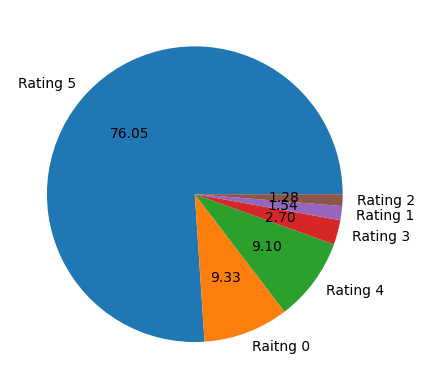

In [15]:
plt.pie(data['Rating'].value_counts(),labels=['Rating 5','Raitng 0','Rating 4','Rating 3','Rating 1','Rating 2'], autopct='%0.2f')
plt.show()

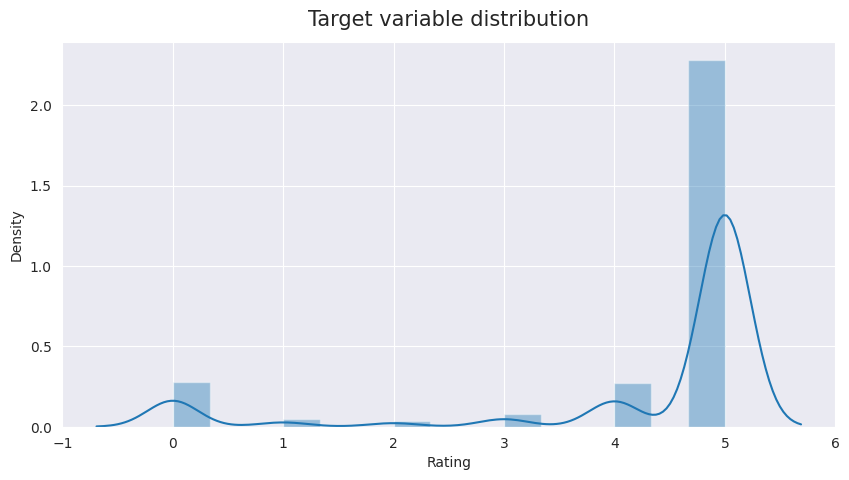

None

-2.1282029504008753

In [16]:
sns.set_style('darkgrid')
plt.figure(figsize = (10, 5))
sns.distplot(data.Rating, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), data.Rating.skew())

1. A negative skewness value indicates that the distribution is skewed towards left

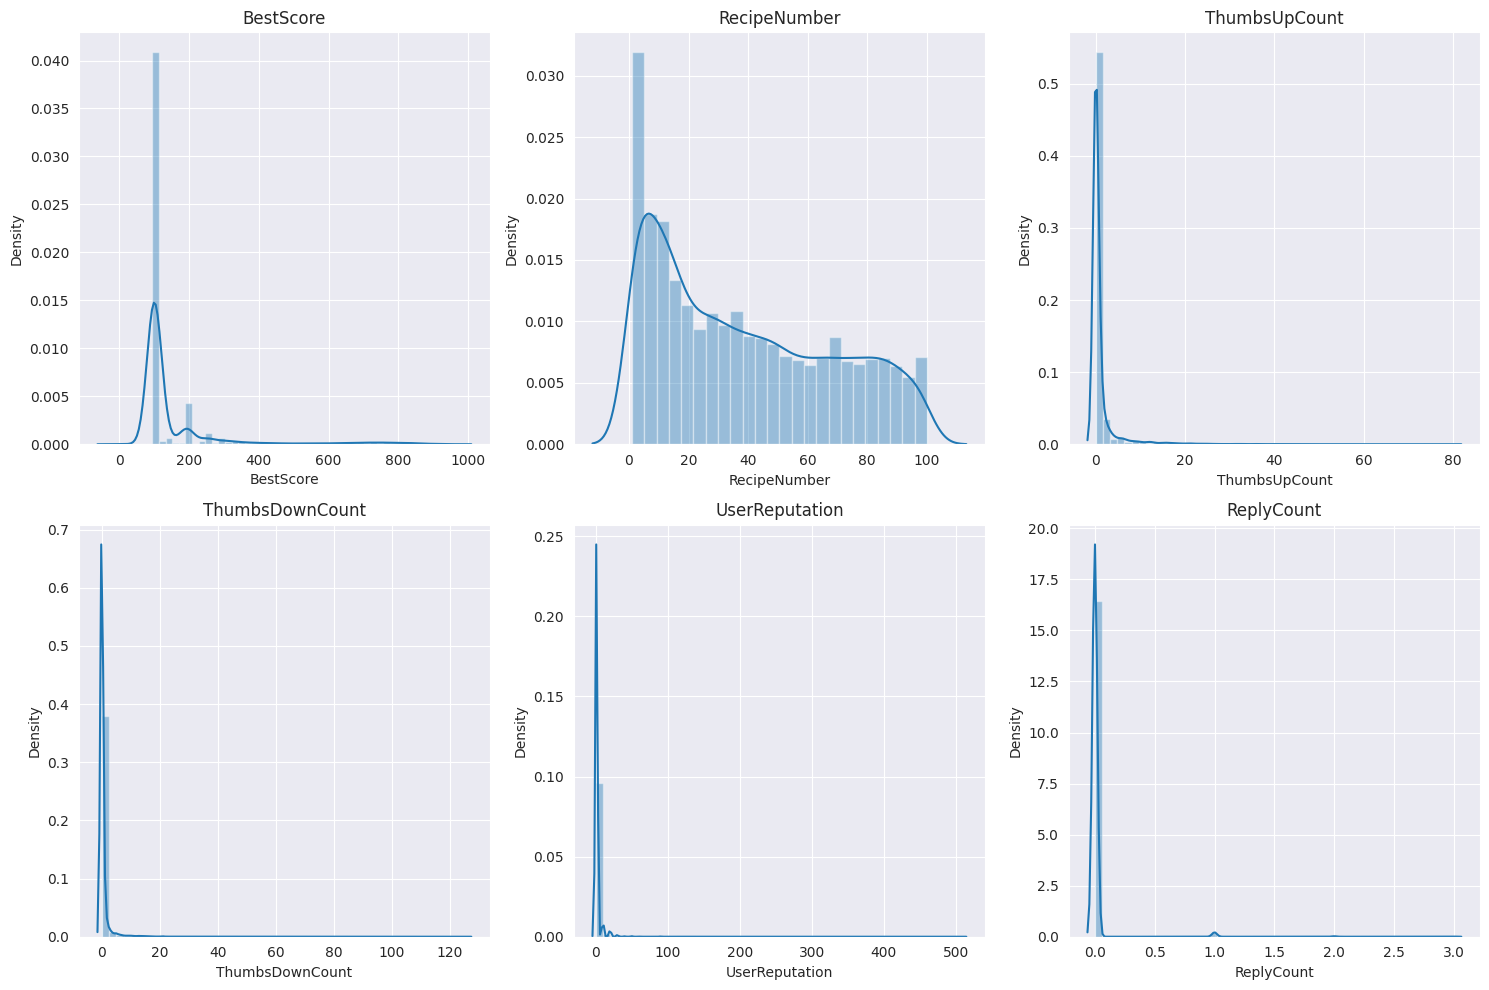

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plot
columns = ['BestScore', 'RecipeNumber', 'ThumbsUpCount', 'ThumbsDownCount', 'UserReputation', 'ReplyCount']

num_plots = len(columns)
num_cols = min(num_plots, 3)  # Display up to 3 plots per row
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows)) # Creating subplots for each column

for i, column in enumerate(columns):
    sns.distplot(data[column], ax=axes[i//num_cols, i%num_cols])  # Accessing subplot using row and column indices
    axes[i//num_cols, i%num_cols].set_title(column)

plt.tight_layout()
plt.show()


* from the above graph we can say that data is right skewed 

# Checking Outliers

<Axes: >

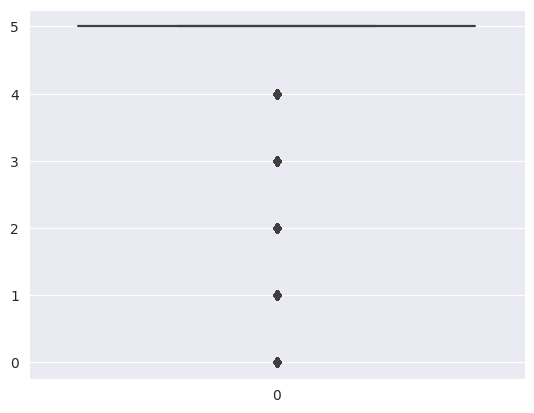

In [93]:
sns.boxplot(data['Rating'])

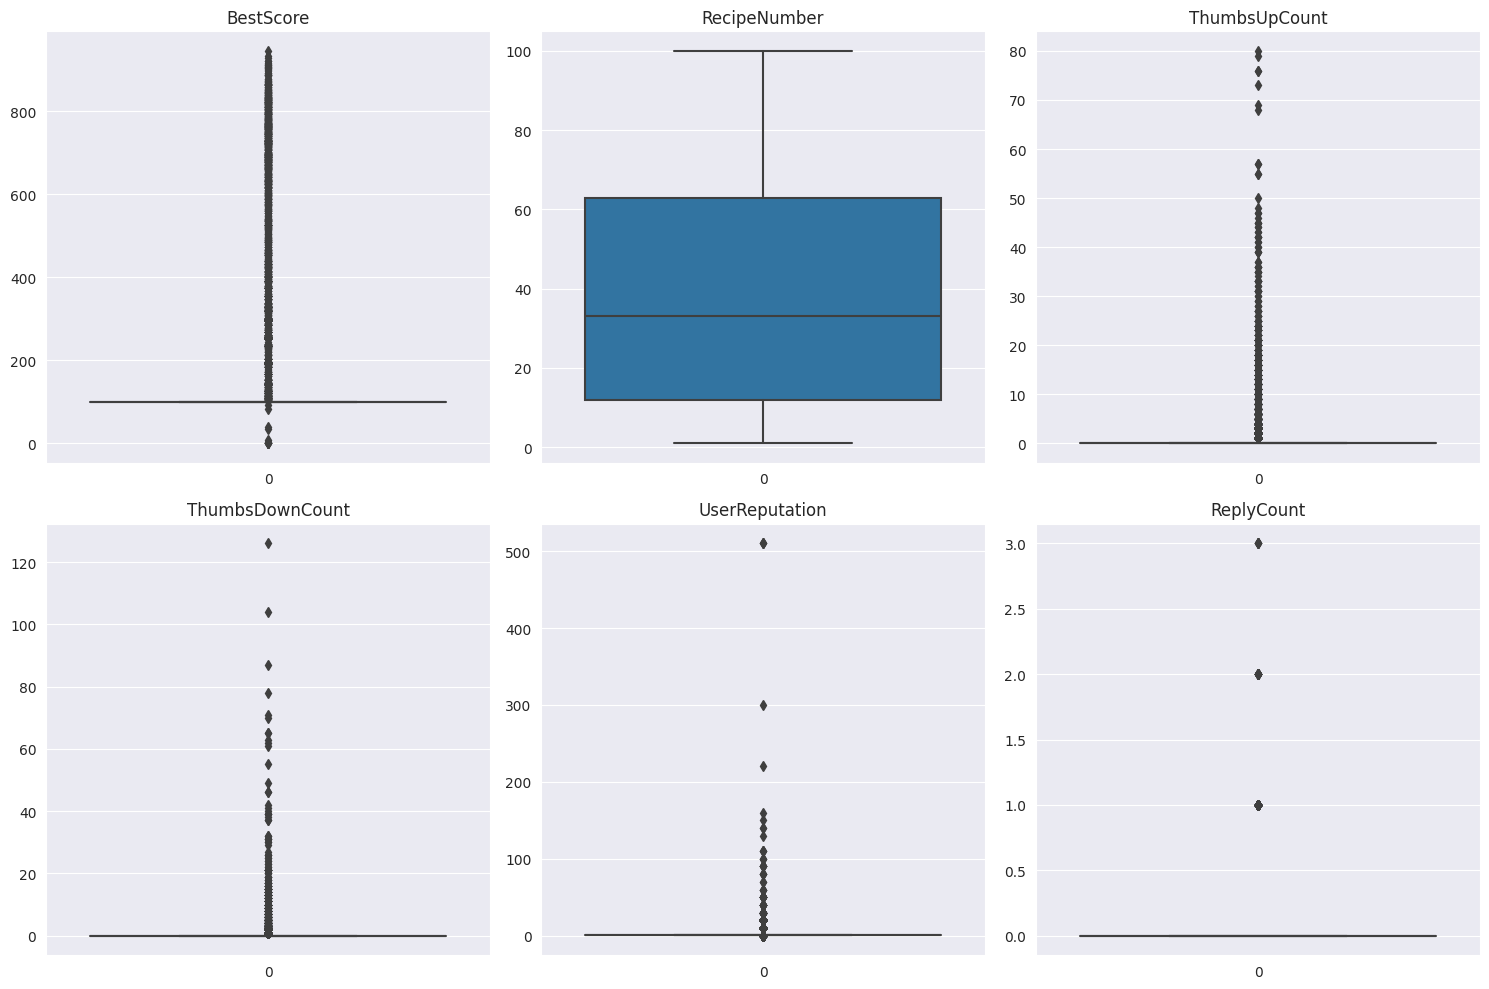

In [18]:
columns = ['BestScore', 'RecipeNumber', 'ThumbsUpCount', 'ThumbsDownCount', 'UserReputation', 'ReplyCount']

num_plots = len(columns)
num_cols = min(num_plots, 3)  # Display up to 3 plots per row
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows)) # Creating subplots for each column

for i, column in enumerate(columns):
    sns.boxplot(data[column], ax=axes[i//num_cols, i%num_cols])  # Accessing subplot using row and column indices
    axes[i//num_cols, i%num_cols].set_title(column)

plt.tight_layout()
plt.show()


# Correlation

<Axes: >

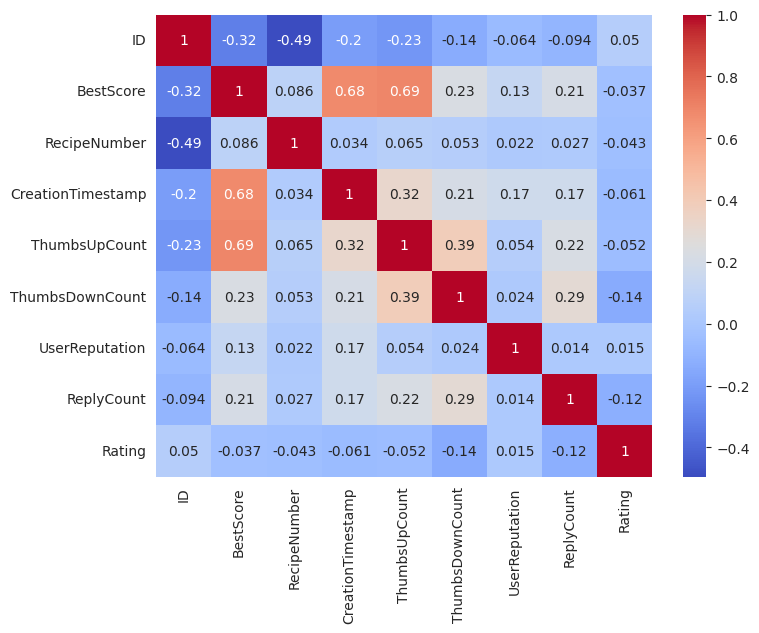

In [19]:
numeric_features =['ID',
                   'BestScore',
                   'RecipeNumber',
                   'CreationTimestamp',
                   'ThumbsUpCount',
                   'ThumbsDownCount',
                   'UserReputation',
                   'ReplyCount',
                   'Rating']
corre= data[numeric_features].corr()
plt.figure(figsize=(8, 6))   
sns.heatmap(corre, annot = True, cmap = 'coolwarm')   # correlation Heat Map

* Their is high correlation between CreationTimestamp, BestScore, ThumbsUpCount


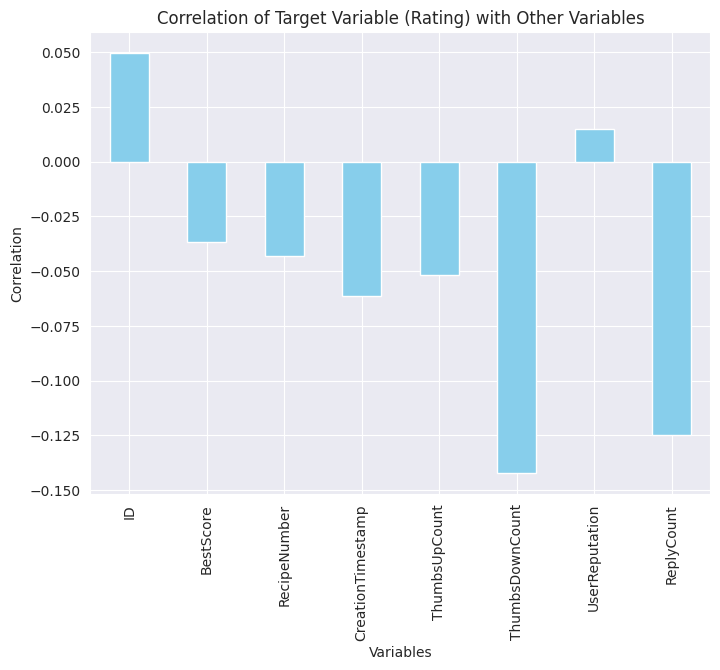

In [20]:
target_correlation = corre['Rating']
plt.figure(figsize=(8, 6))
target_correlation.drop('Rating').plot(kind='bar', color='skyblue')
plt.title('Correlation of Target Variable (Rating) with Other Variables')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()


In [21]:
columns=['CommentID','UserName','UserID','CreationTimestamp','BestScore'] # dropping columns
data=data.drop(columns=columns)

CommentID,UserName,UserId might not be usefull for predicting Rating
as each user will be associated will only one or few recipes.

CreationTimestamp,BestScore have positive correlation with ThumbsUpCount 

In [22]:
data.head()

,ID,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,20,0,0,0,5,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,1,0,0,1,5,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,1,0,0,0,3,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,1,0,0,0,5,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,1,0,0,0,4,Great basic recipe. I added 2 teaspoons Tuscan...


# Text Preprocessing

In [23]:
def clean_text(text):
    if not isinstance(text, str):  # Checking if non-string (e.g., NaN)
        return ''
    
    text = text.lower()  # Converting to lowercase
    
    text = re.sub(r'http\S+', '', text)  # Removing links
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Removing punctuation
    
    return text

data['Recipe_Review'] = data['Recipe_Review'].apply(clean_text)


In [24]:
data['Recipe_Review']

0        great recipe i have made them just as written ...
1        this is an easy and quick recipe that is great...
2        i think i was looking for something extra spec...
3        this is our favorite grilled chicken recipe  g...
4        great basic recipe i added  teaspoons tuscan s...
                               ...                        
13631    delicious very easy to make one minor change  ...
13632    i made this pie for my family and they loved i...
13633                                           very tasty
13634    i have made this numerous times  its so good a...
13635    super i added  lb chopped bacon to mine have s...
Name: Recipe_Review, Length: 13634, dtype: object

# Encoding RecipeName

In [25]:
encoder = LabelEncoder()
data["RecipeName"]=encoder.fit_transform(data["RecipeName"])
RecipeName_no={ index: label for index, label in enumerate(encoder.classes_)}
RecipeName_no

{0: 'Amish Breakfast Casserole',
 1: 'Apple Pie',
 2: 'Asian Chicken Thighs',
 3: 'Bacon Macaroni Salad',
 4: 'Baked Mushroom Chicken',
 5: 'Baked Spaghetti',
 6: 'Baked Tilapia',
 7: 'Banana Bars with Cream Cheese Frosting',
 8: 'Basic Banana Muffins',
 9: 'Basic Homemade Bread',
 10: 'Best Ever Banana Bread',
 11: 'Best Ever Potato Soup',
 12: 'Big Soft Ginger Cookies',
 13: 'Black Bean ‘n’ Pumpkin Chili',
 14: 'Blueberry French Toast',
 15: 'Brown Sugar Oatmeal Pancakes',
 16: 'Bruschetta Chicken',
 17: 'Buttery Cornbread',
 18: 'Caramel Heavenlies',
 19: 'Caramel-Pecan Cheesecake Pie',
 20: 'Cauliflower Soup',
 21: 'Cheeseburger Paradise Soup',
 22: 'Cheeseburger Soup',
 23: 'Cheesy Ham Chowder',
 24: 'Cherry Bars',
 25: 'Chicken Penne Casserole',
 26: 'Chicken Wild Rice Soup',
 27: 'Chicken and Dumplings',
 28: 'Chocolate Caramel Candy',
 29: 'Chocolate Chip Oatmeal Cookies',
 30: 'Chocolate Guinness Cake',
 31: 'Chocolate-Strawberry Celebration Cake',
 32: 'Chunky Apple Cake',
 3

# Splitting Dataset into train and test data

In [26]:
X=data.drop('Rating', axis=1)
y=data['Rating']
X.shape, y.shape

((13634, 9), (13634,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((10907, 9), (2727, 9))

In [28]:
X_train_num=X_train.drop('Recipe_Review',axis=1)
X_test_num=X_test.drop('Recipe_Review',axis=1)

In [29]:
X_train_txt=X_train['Recipe_Review']
X_test_txt=X_test['Recipe_Review']
X_train_txt

8376     wvallj i think that applesauce would be an ide...
8945     when i make chili i brown the meat then add al...
12430    so easy and good  i substituted broccoli for c...
532      my pie did not turn out as expected was very d...
12109    very delicious and moist i cut the sugar down ...
                               ...                        
5192     i have tried many banana bread receipes but th...
13420    i made it for my clients and they asked for it...
5391     this sounds good i havent tried the recipe yet...
860      its not even finished yet n it already smells ...
7271     these are absolutely the best ginger cookies e...
Name: Recipe_Review, Length: 10907, dtype: object

# Converting text data into numerical data

In [30]:
#Using TF- IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000) # Extracting 2000 features
X_train_txt_vec=vectorizer.fit_transform(X_train_txt)
X_test_txt_vec=vectorizer.transform(X_test_txt)
X_train_txt_vec

<10907x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 153970 stored elements in Compressed Sparse Row format>

In [31]:
X_train_txt_vec[1].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

# Scaling Numerical Features

In [32]:
ss=StandardScaler()
X_train_num_ss = pd.DataFrame( ss.fit_transform(X_train_num),columns=X_train_num.columns )
X_test_num_ss = pd.DataFrame( ss.transform(X_test_num),columns=X_test_num.columns )
X_train_num_ss.head()

,ID,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount
0,0.090818,0.153002,0.492236,-0.544813,-0.11861,-0.106939,-0.266109,-0.164163
1,-0.156661,0.220371,0.822812,-1.201762,-0.11861,-0.106939,-0.266109,-0.164163
2,-0.105458,-0.891217,-0.080173,-0.959728,-0.11861,-0.106939,-0.266109,-0.164163
3,-0.387073,0.085633,0.596117,-0.994304,-0.11861,-0.106939,-0.266109,-0.164163
4,-0.190796,-0.082789,-0.853130,0.872813,-0.11861,-0.106939,-0.266109,-0.164163


# Combining both text data and numerical data

In [33]:
X_train_combined = np.hstack([X_train_num_ss,X_train_txt_vec.toarray()] )
X_test_combined = np.hstack([X_test_num_ss,X_test_txt_vec.toarray()] )
X_train_combined.shape

(10907, 2008)

# Model Building

# Logistic Regression 

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_combined,y_train)

LogisticRegression(max_iter=1000)

In [35]:
print('Training Score:',lr.score(X_train_combined,y_train)) 

Training Score: 0.7977445677088109


In [36]:
y_pred = lr.predict(X_test_combined) 
print('Testing Score:',lr.score(X_test_combined,y_test))

Testing Score: 0.7796112944627797


In [37]:
y_score_lr=lr.predict_proba(X_test_combined)
y_score_lr

array([[0.06464299, 0.00474479, 0.00426763, 0.00549027, 0.03364101,
        0.88721331],
       [0.27919533, 0.01791249, 0.0391224 , 0.0661194 , 0.10875995,
        0.48889043],
       [0.17377248, 0.03017753, 0.03347985, 0.0347757 , 0.04925929,
        0.67853516],
       ...,
       [0.07145052, 0.00981957, 0.00751288, 0.00537392, 0.01683546,
        0.88900765],
       [0.02136899, 0.00895979, 0.00753234, 0.00646007, 0.08323399,
        0.87244483],
       [0.05472267, 0.01390582, 0.00918036, 0.06183355, 0.22112322,
        0.63923438]])

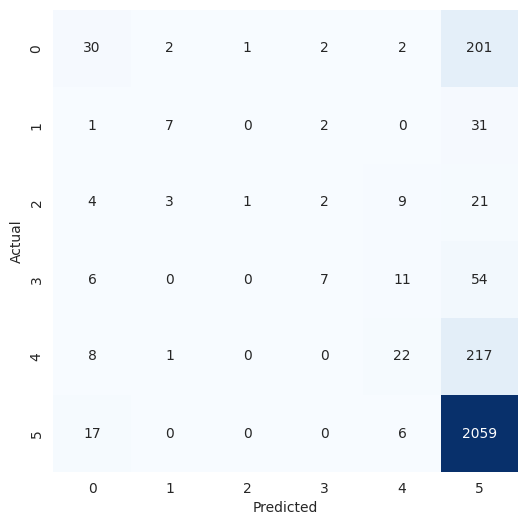

Classification Report:
-------------------
               precision    recall  f1-score   support

           0       0.45      0.13      0.20       238
           1       0.54      0.17      0.26        41
           2       0.50      0.03      0.05        40
           3       0.54      0.09      0.15        78
           4       0.44      0.09      0.15       248
           5       0.80      0.99      0.88      2082

    accuracy                           0.78      2727
   macro avg       0.54      0.25      0.28      2727
weighted avg       0.72      0.78      0.71      2727



In [38]:
cm = confusion_matrix(y_test, y_pred)
clr= classification_report(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Classification Report:\n-------------------\n', clr)

# LogisticRegression(with Hyperparameter)

In [39]:
# lr=LogisticRegression(max_iter=20000)
# param_grid= {'C': [0.01, 0.1, 1, 10, 100],
#             'penalty': ['l1','l2'],
#             'solver': ['lbfgs','liblinear','newton-cg'],
#             'multi_class':['auto','ovr']
#           }

# grid= GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
# grid.fit(X_train_combined, y_train)
# best_params = grid.best_params_
# best_params

In [40]:
lrhp=LogisticRegression(C=10,
                        penalty='l2',
                        solver='newton-cg',
                        multi_class='ovr')
lrhp.fit(X_train_combined,y_train)

LogisticRegression(C=10, multi_class='ovr', solver='newton-cg')

In [41]:
print('Training Score:',lrhp.score(X_train_combined,y_train)) 

Training Score: 0.8526634271568717


In [42]:
y_pred = lrhp.predict(X_test_combined) 
print('Testing Score:',lrhp.score(X_test_combined,y_test))

Testing Score: 0.7667766776677668


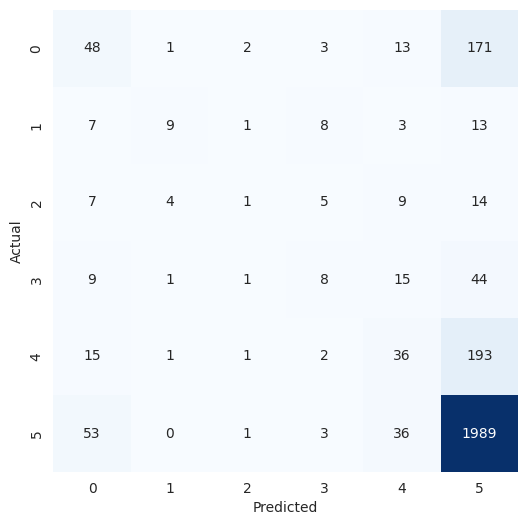

Classification Report:LogisticRegression
-------------------
               precision    recall  f1-score   support

           0       0.35      0.20      0.25       238
           1       0.56      0.22      0.32        41
           2       0.14      0.03      0.04        40
           3       0.28      0.10      0.15        78
           4       0.32      0.15      0.20       248
           5       0.82      0.96      0.88      2082

    accuracy                           0.77      2727
   macro avg       0.41      0.27      0.31      2727
weighted avg       0.70      0.77      0.72      2727



In [43]:
cm = confusion_matrix(y_test, y_pred)
clr= classification_report(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Classification Report:LogisticRegression\n-------------------\n', clr)

# RandomForest Classsifier

In [44]:
rfc=RandomForestClassifier()
rfc.fit(X_train_combined,y_train)

RandomForestClassifier()

In [45]:
print('Traning Score:', rfc.score(X_train_combined,y_train))

Traning Score: 1.0


In [46]:
y_pred = rfc.predict(X_test_combined) 
print('Testing Score:',rfc.score(X_test_combined,y_test))

Testing Score: 0.7733773377337734


In [47]:
y_score_rfc=rfc.predict_proba(X_test_combined)
y_score_rfc

array([[0.03, 0.  , 0.  , 0.  , 0.07, 0.9 ],
       [0.11, 0.  , 0.02, 0.  , 0.11, 0.76],
       [0.05, 0.1 , 0.07, 0.05, 0.07, 0.66],
       ...,
       [0.18, 0.01, 0.  , 0.  , 0.01, 0.8 ],
       [0.03, 0.02, 0.  , 0.01, 0.11, 0.83],
       [0.07, 0.02, 0.  , 0.04, 0.14, 0.73]])

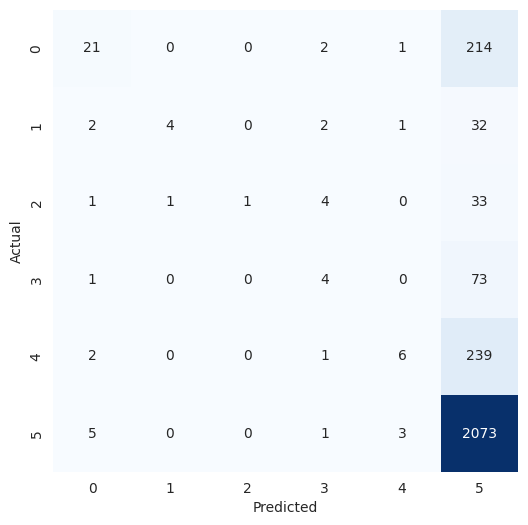

Classification Report:
-------------------
               precision    recall  f1-score   support

           0       0.66      0.09      0.16       238
           1       0.80      0.10      0.17        41
           2       1.00      0.03      0.05        40
           3       0.29      0.05      0.09        78
           4       0.55      0.02      0.05       248
           5       0.78      1.00      0.87      2082

    accuracy                           0.77      2727
   macro avg       0.68      0.21      0.23      2727
weighted avg       0.74      0.77      0.69      2727



In [48]:
cm = confusion_matrix(y_test, y_pred)
clr= classification_report(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Classification Report:\n-------------------\n', clr)

# RandomForestClassifier (With HyperParameter)

In [49]:
# param_grid = {
#    'n_estimators': [100,200],
#    'max_depth': [10, 15],
#    'criterion':['gini','entropy'],
#    'min_samples_split': [5, 10],
#    'min_samples_leaf': [2, 4]
# }
# grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy',verbose=2, n_jobs=-1)
# grid_search.fit(X_train_combined, y_train)

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)

In [50]:
rfchp=RandomForestClassifier(n_estimators = 100,
                             min_samples_split = 5, 
                             min_samples_leaf = 2, 
                             max_depth = 15, 
                             criterion = 'entropy')
rfchp.fit(X_train_combined,y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2,
                       min_samples_split=5)

In [51]:
print('Traning Score:', rfchp.score(X_train_combined,y_train))

Traning Score: 0.7597872925644081


In [52]:
y_pred = rfchp.predict(X_test_combined) 
print('Testing Score:',rfchp.score(X_test_combined,y_test))

Testing Score: 0.7634763476347635


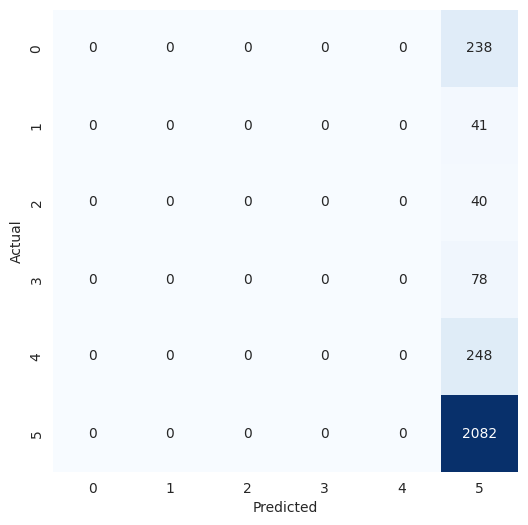

Classification Report:RandomForestClassifier
-------------------
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       238
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        78
           4       0.00      0.00      0.00       248
           5       0.76      1.00      0.87      2082

    accuracy                           0.76      2727
   macro avg       0.13      0.17      0.14      2727
weighted avg       0.58      0.76      0.66      2727



In [53]:
cm = confusion_matrix(y_test, y_pred)
clr= classification_report(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Classification Report:RandomForestClassifier\n-------------------\n', clr)

# HistGradientBoostingClassifier 

In [54]:
clf=HistGradientBoostingClassifier()
clf.fit(X_train_combined,y_train)

HistGradientBoostingClassifier()

In [55]:
print('Training Score:',clf.score(X_train_combined,y_train)) 

Training Score: 0.8647657467681306


In [56]:
y_pred = clf.predict(X_test_combined) 
print('Testing Score:',clf.score(X_test_combined,y_test))

Testing Score: 0.7803447011367803


In [57]:
y_score_clf=clf.predict_proba(X_test_combined)
y_score_clf

array([[2.68349458e-02, 2.11951705e-03, 5.42978330e-04, 1.41662769e-03,
        2.37489930e-02, 9.45336938e-01],
       [2.24409899e-01, 9.97918938e-03, 9.04692673e-03, 8.40097930e-03,
        1.09491161e-01, 6.38671845e-01],
       [7.47917700e-02, 1.37805937e-02, 3.61316110e-03, 3.55286411e-03,
        3.12403226e-02, 8.73021288e-01],
       ...,
       [8.02461647e-02, 6.44942436e-03, 6.11696346e-03, 4.73943637e-03,
        3.44199526e-02, 8.68028059e-01],
       [2.19157845e-02, 4.42958668e-03, 2.32180511e-03, 6.28293930e-03,
        9.99337552e-02, 8.65116129e-01],
       [4.99483586e-02, 3.36424623e-03, 1.34939505e-03, 6.79278461e-02,
        2.17409785e-01, 6.60000369e-01]])

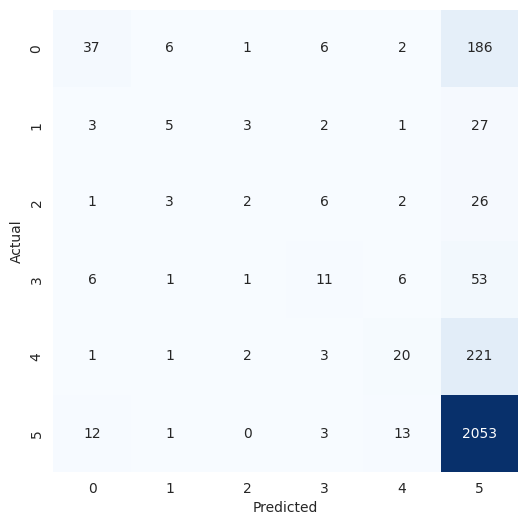

Classification Report: GradientBoostingClassifier
-------------------
               precision    recall  f1-score   support

           0       0.62      0.16      0.25       238
           1       0.29      0.12      0.17        41
           2       0.22      0.05      0.08        40
           3       0.35      0.14      0.20        78
           4       0.45      0.08      0.14       248
           5       0.80      0.99      0.88      2082

    accuracy                           0.78      2727
   macro avg       0.46      0.26      0.29      2727
weighted avg       0.72      0.78      0.72      2727



In [58]:
cm = confusion_matrix(y_test, y_pred)
clr= classification_report(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Classification Report: GradientBoostingClassifier\n-------------------\n', clr)

# XG Boost

In [59]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_combined,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [60]:
print("Traning score:",xgb.score(X_train_combined,y_train))

Traning score: 0.8964884936279454


In [61]:
y_pred = xgb.predict(X_test_combined)
print("Testing score:",xgb.score(X_test_combined,y_test))

Testing score: 0.7832783278327833


In [62]:
y_score_xgb=xgb.predict_proba(X_test_combined)
y_score_xgb

array([[6.5309502e-02, 3.8174395e-03, 6.1275647e-04, 3.0703372e-03,
        2.6416752e-02, 9.0077317e-01],
       [1.2525383e-01, 9.3385838e-03, 1.3339717e-02, 9.2534367e-03,
        8.9144044e-02, 7.5367033e-01],
       [5.3055923e-02, 1.2306247e-03, 8.1262150e-04, 3.0513816e-03,
        3.4269955e-02, 9.0757942e-01],
       ...,
       [8.5761160e-02, 1.1329197e-02, 1.1586049e-02, 6.3880649e-03,
        4.7122296e-02, 8.3781320e-01],
       [3.3455867e-02, 3.6773158e-03, 4.9402192e-03, 8.4833046e-03,
        9.7718582e-02, 8.5172474e-01],
       [4.7422338e-02, 2.5455843e-04, 1.5883342e-03, 5.7589110e-02,
        1.5790105e-01, 7.3524463e-01]], dtype=float32)

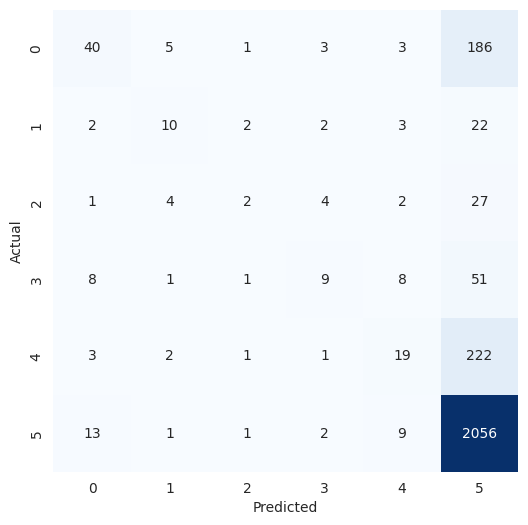

Classification Report:XGBoostClassifier
-------------------
               precision    recall  f1-score   support

           0       0.60      0.17      0.26       238
           1       0.43      0.24      0.31        41
           2       0.25      0.05      0.08        40
           3       0.43      0.12      0.18        78
           4       0.43      0.08      0.13       248
           5       0.80      0.99      0.89      2082

    accuracy                           0.78      2727
   macro avg       0.49      0.27      0.31      2727
weighted avg       0.73      0.78      0.72      2727



In [63]:
cm = confusion_matrix(y_test, y_pred)
clr= classification_report(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Classification Report:XGBoostClassifier\n-------------------\n', clr)

# Acurracy of Models

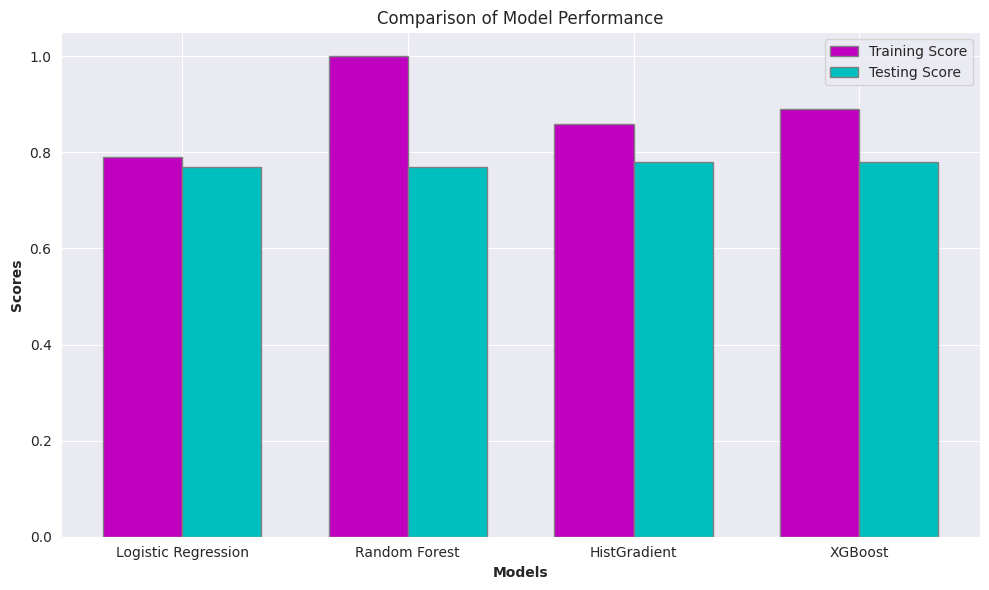

In [64]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Random Forest', 'HistGradient','XGBoost']
training_scores = [0.79, 1.0, 0.86, 0.89]
testing_scores = [0.77, 0.77, 0.78, 0.78]

bar_width = 0.35

r1 = range(len(models))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(10, 6))
plt.bar(r1, training_scores, color='m', width=bar_width, edgecolor='grey', label='Training Score')
plt.bar(r2, testing_scores, color='c', width=bar_width, edgecolor='grey', label='Testing Score')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.title('Comparison of Model Performance')
plt.legend()

plt.tight_layout()
plt.show()


# ROC 

In [65]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(2727, 6)

In [66]:
label_binarizer.transform([3])

array([[0, 0, 0, 1, 0, 0]])

In [67]:
classes = label_binarizer.classes_
classes

array([0, 1, 2, 3, 4, 5])

In [68]:
model_names=['LogisticRegression', 'RandomForest', 'HistGradientBoosting', 'XGBoost']

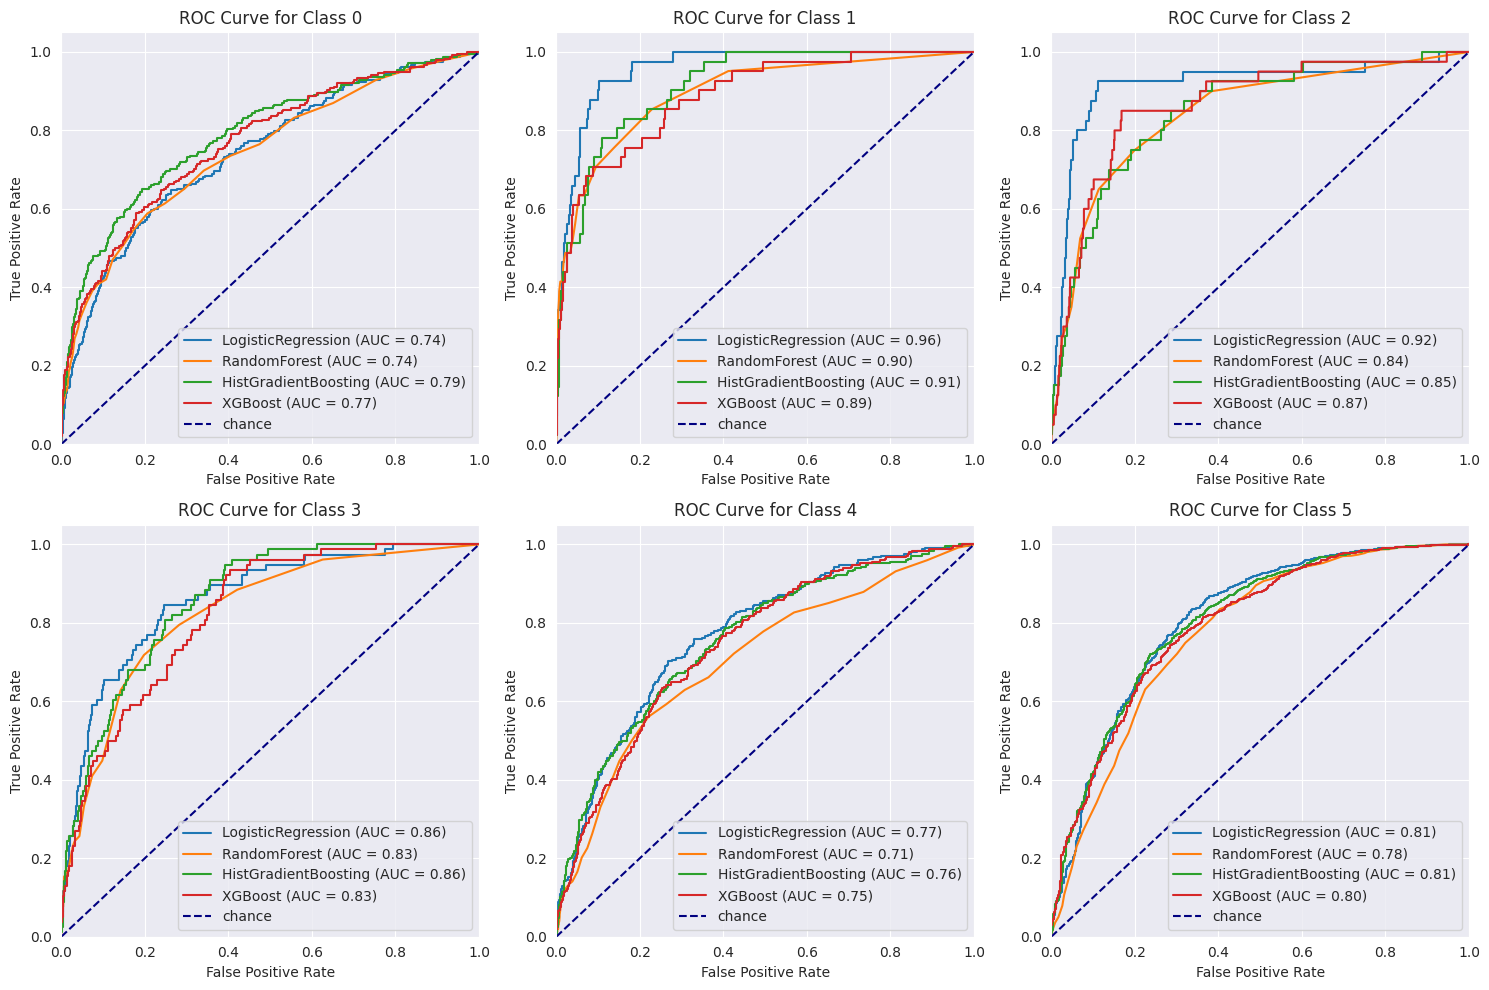

In [69]:
def plot_roc_curves_for_classes(y_train, y_scores_list, classes, model_names):
    # Compute the number of rows and columns for subplots
    num_plots = len(classes)
    num_cols = min(num_plots, 3)  # Display 3 plots per row
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.flatten()  # Flatten the 2D array of subplots to simplify indexing

    # Iterate over each class
    for i, class_label in enumerate(classes):
        # Select the appropriate subplot
        ax = axs[i]

        # Iterate over each model and plot its ROC curve for the current class
        for model_name, y_scores in zip(model_names, y_scores_list):
            fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

        
        ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='chance') 


        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for Class {class_label}')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

plot_roc_curves_for_classes(y_train, [y_score_lr, y_score_rfc, y_score_clf, y_score_xgb], classes, ['LogisticRegression', 'RandomForest', 'HistGradientBoosting', 'XGBoost'])


# Accuracy

1. LogisticRegression 
* Traning score: 0.79
* Testing score: 0.77

3. RandomForestClassifier
* Traning score: 1.0
* Testing score: 0.77

3. HistGradientBoosting  
* Traning score: 0.86
* Testing score: 0.78

4. XGBoostClassifier
* Traning score: 0.89
* Testing score: 0.78

1. Logistic Regression has slightly lower testing score compared to HistGradient Boosting.
1. Random Forest has a perfect training score but slightly lower testing score compared to HistGradient Boosting.(which indicates overfitting)

# We will prefer HistGradientBoosting Classifier
1. HistGradient Boosting has the highest testing score among all models and a relatively high training score, indicating good generalization and performance.
1. Highest Testing Score indicates that it perform better on unseen data. 
1. As data contains outliers HistGradient Boosting is robust to outliers compared to Logistic which can be sensitive to outliers.


# Using Pipelines

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin
import re

class TextPreprocessor(BaseEstimator, TransformerMixin):   #Custom transformer
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_lower = X.str.lower()                                                    
        X_no_links = X_lower.apply(lambda x: re.sub(r'http\S+', '', x)) 
        X_cleaned = X_no_links.str.replace(r'[^a-zA-Z\s]', '', regex=True)
        return X_cleaned

In [71]:
text_preprocessor = Pipeline([
    ('text_preprocessing', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(stop_words='english',max_features=2000))
])
text_preprocessor

Pipeline(steps=[('text_preprocessing', TextPreprocessor()),
                ('tfidf',
                 TfidfVectorizer(max_features=2000, stop_words='english'))])

In [72]:
column_transformer = ColumnTransformer([
    ('text', text_preprocessor, 'Recipe_Review'),
    ('encoder', OneHotEncoder(sparse=False,drop='first'), ['RecipeName']),
    ('scaler', StandardScaler(), ['RecipeNumber', 'RecipeCode', 'UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount'])
])
column_transformer

ColumnTransformer(transformers=[('text',
                                 Pipeline(steps=[('text_preprocessing',
                                                  TextPreprocessor()),
                                                 ('tfidf',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'))]),
                                 'Recipe_Review'),
                                ('encoder',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['RecipeName']),
                                ('scaler', StandardScaler(),
                                 ['RecipeNumber', 'RecipeCode',
                                  'UserReputation', 'ReplyCount',
                                  'ThumbsUpCount', 'ThumbsDownCount'])])

In [73]:
pipeline = Pipeline([
    ('preprocessor', column_transformer)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('text_preprocessing',
                                                                   TextPreprocessor()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=2000,
                                                                                   stop_words='english'))]),
                                                  'Recipe_Review'),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['RecipeName']),
                                                 ('scaler', StandardScaler(),
                                                  ['RecipeNumber', 'RecipeCode',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount'])]))])

In [74]:
transformed_X = pipeline.fit_transform(X)
transformed_X

<13634x2105 sparse matrix of type '<class 'numpy.float64'>'
	with 288836 stored elements in Compressed Sparse Row format>

In [75]:
histclf=HistGradientBoostingClassifier()
histclf.fit(transformed_X.toarray(),y)

HistGradientBoostingClassifier()

In [76]:
histclf.score(transformed_X.toarray(),y)

0.8752383746516063

# Test Data

In [77]:
test=pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

In [78]:
test.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...


In [79]:
#dropping irrelevent columns
test=test.drop(columns=columns)

In [80]:
#label encoder
test["RecipeName"]=encoder.transform(test["RecipeName"])

In [81]:
test['Recipe_Review'] = test['Recipe_Review'].apply(clean_text)

In [82]:
test.head()

,ID,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Recipe_Review
0,86,45,41384,13,1,0,0,0,this was so good the pumpkin was perfect as a...
1,102,53,3143,72,1,0,0,1,so good could not stop eating them so bad ...
2,156,53,3143,72,1,0,0,0,i use a small ladle to fill muffin cups
3,18,89,1324,70,1,0,4,3,i made this and followed the instructions as d...
4,27,70,32264,40,1,0,0,1,very good i used corn tortillas used fresh c...


In [83]:
test_num=test.drop('Recipe_Review', axis=1)
test_txt=test['Recipe_Review']

In [84]:
test_num

,ID,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount
0,86,45,41384,13,1,0,0,0
1,102,53,3143,72,1,0,0,1
2,156,53,3143,72,1,0,0,0
3,18,89,1324,70,1,0,4,3
4,27,70,32264,40,1,0,0,1
...,...,...,...,...,...,...,...,...
4541,152,32,17310,80,1,0,0,0
4542,121,74,26937,69,1,0,0,0
4543,133,73,41095,34,1,0,0,0
4544,91,12,19731,20,1,0,0,1


In [85]:
# Scaling 
test_num_ss=pd.DataFrame( ss.transform(test_num),columns=test_num.columns )
test_num_ss

,ID,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount
0,-0.301735,0.220371,0.822812,-1.201762,-0.11861,-0.106939,-0.266109,-0.164163
1,-0.165195,0.489847,-0.771935,0.838237,-0.11861,-0.106939,-0.266109,0.126838
2,0.295629,0.489847,-0.771935,0.838237,-0.11861,-0.106939,-0.266109,-0.164163
3,-0.882031,1.702488,-0.847792,0.769085,-0.11861,-0.106939,0.702586,0.708840
4,-0.805227,1.062483,0.442485,-0.268203,-0.11861,-0.106939,-0.266109,0.126838
...,...,...,...,...,...,...,...,...
4541,0.261494,-0.217527,-0.181135,1.114847,-0.11861,-0.106939,-0.266109,-0.164163
4542,-0.003053,1.197221,0.220335,0.734508,-0.11861,-0.106939,-0.266109,-0.164163
4543,0.099352,1.163537,0.810760,-0.475660,-0.11861,-0.106939,-0.266109,-0.164163
4544,-0.259066,-0.891217,-0.080173,-0.959728,-0.11861,-0.106939,-0.266109,0.126838


In [86]:
# converting text data into number
test_txt_vec=vectorizer.transform(test_txt)
test_txt_vec

<4546x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 63807 stored elements in Compressed Sparse Row format>

In [87]:
#combining both text and numerical data
test_combined=np.hstack([test_num_ss,test_txt_vec.toarray()])
test_combined.shape

(4546, 2008)

In [88]:
prediction=clf.predict(test_combined)
prediction

array([5, 5, 5, ..., 5, 2, 5])

# Using Pipeline

In [89]:
transformed_test=pipeline.transform(test)
transformed_test

<4546x2105 sparse matrix of type '<class 'numpy.float64'>'
	with 95594 stored elements in Compressed Sparse Row format>

In [90]:
predictionpipe=histclf.predict(transformed_test.toarray())
predictionpipe

array([5, 5, 5, ..., 5, 1, 5])

# Submission

In [91]:
submission=pd.DataFrame({'ID': range(1,4547),
                         'Rating': predictionpipe})

submission.to_csv("submission.csv", index=False)

In [92]:
submission["Rating"].value_counts()

Rating
5    4195
0     133
4     111
3      58
1      34
2      15
Name: count, dtype: int64